In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import torch
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Loading the datasets

In [ ]:
# project folder
deep_learning_dir = "/content/gdrive/My Drive/BMI 707 Project"

In [ ]:
# get nctid's and labels
train = pd.read_csv(deep_learning_dir + "/data_formatting/training_data.tsv", sep="\t")
val = pd.read_csv(deep_learning_dir + "/data_formatting/validation_data.tsv", sep="\t")
test = pd.read_csv(deep_learning_dir + "/data_formatting/testing_data.tsv", sep="\t")

train_nctids = train["nctid"].to_numpy()
train_labels = train["label"].to_numpy()

val_nctids = val["nctid"].to_numpy()
val_labels = val["label"].to_numpy()

test_nctids = test["nctid"].to_numpy()
test_labels = test["label"].to_numpy()

Loading the embeddings

In [ ]:
## diseases
with open(deep_learning_dir + "/embeddings/nctid2diseases.pkl", "rb") as handle:
  nctid2diseases = pickle.load(handle)


## eligibility criteria
with open(deep_learning_dir + "/embeddings/nctid2incl_criteria.pkl", "rb") as handle:
  nctid2incl_criteria = pickle.load(handle)

with open(deep_learning_dir + "/embeddings/nctid2excl_criteria.pkl", "rb") as handle:
  nctid2excl_criteria = pickle.load(handle)


## drugs
with open(deep_learning_dir + "/embeddings/nctid2drugs.pkl", "rb") as handle:
  nctid2drugs = pickle.load(handle)


## targets
with open(deep_learning_dir + "/embeddings/nctid2drug_targets.pkl", "rb") as handle:
  nctid2target = pickle.load(handle)

In [ ]:
# convert to np array
for nctid in nctid2diseases:
  nctid2incl_criteria[nctid] = nctid2incl_criteria[nctid].numpy()
  nctid2excl_criteria[nctid] = nctid2excl_criteria[nctid].numpy()
  
  if nctid in nctid2target:
    nctid2target[nctid] = nctid2target[nctid].numpy()
  else:
    nctid2target[nctid] = np.zeros(1024, dtype=np.float32)

In [ ]:
## meta data
with open(deep_learning_dir + "/embeddings/nctid2n_diseases.pkl", "rb") as handle:
  nctid2n_diseases = pickle.load(handle)


with open(deep_learning_dir + "/embeddings/length_nctid2incl_criteria.pkl", "rb") as handle:
  nctid2n_incl = pickle.load(handle)

with open(deep_learning_dir + "/embeddings/length_nctid2excl_criteria.pkl", "rb") as handle:
  nctid2n_excl = pickle.load(handle)

with open(deep_learning_dir + "/embeddings/nctid2npart_success.pkl", "rb") as handle:
  nctid2npart_success = pickle.load(handle)

In [ ]:
# concatenate meta info
nctid2meta = {}

for nctid in nctid2diseases:
  nctid2meta[nctid] = np.array([nctid2n_diseases[nctid], nctid2n_incl[nctid], nctid2n_excl[nctid], 
                                nctid2npart_success[nctid][0], nctid2npart_success[nctid][1]])

Build input data for the base models.

In [ ]:
def build_data(nctids, nctid_dict):
  """
  Build NN input matrix for given list of nctid's and a dictionary,
  which maps an nctid to an embedding.
  """
  n_rows = len(nctids)
  n_cols = len(list(nctid_dict.values())[0])

  data = np.zeros((n_rows, n_cols), dtype=float)

  for i,nctid in enumerate(nctids):
    
    data[i,:] = nctid_dict[nctid]


  df = pd.DataFrame(data)
  df = df.set_index(nctids)
  return df

In [ ]:
# train inputs
train_data_diseases = build_data(train_nctids, nctid2diseases)
train_data_incl = build_data(train_nctids, nctid2incl_criteria)
train_data_excl = build_data(train_nctids, nctid2excl_criteria)
train_data_drug = build_data(train_nctids, nctid2drugs)
train_data_target = build_data(train_nctids, nctid2target)
train_data_meta = build_data(train_nctids, nctid2meta)

train_data = pd.concat([train_data_diseases, train_data_incl, train_data_excl, train_data_drug, train_data_target, train_data_meta], axis=1)

# validation inputs
val_data_diseases = build_data(val_nctids, nctid2diseases)
val_data_incl = build_data(val_nctids, nctid2incl_criteria)
val_data_excl = build_data(val_nctids, nctid2excl_criteria)
val_data_drug = build_data(val_nctids, nctid2drugs)
val_data_target = build_data(val_nctids, nctid2target)
val_data_meta = build_data(val_nctids, nctid2meta)

val_data = pd.concat([val_data_diseases, val_data_incl, val_data_excl, val_data_drug, val_data_target, val_data_meta], axis=1)


# test inputs
test_data_diseases = build_data(test_nctids, nctid2diseases)
test_data_incl = build_data(test_nctids, nctid2incl_criteria)
test_data_excl = build_data(test_nctids, nctid2excl_criteria)
test_data_drug = build_data(test_nctids, nctid2drugs)
test_data_target = build_data(test_nctids, nctid2target)
test_data_meta = build_data(test_nctids, nctid2meta)

test_data = pd.concat([test_data_diseases, test_data_incl, test_data_excl, test_data_drug, test_data_target, test_data_meta], axis=1)


In [ ]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,0,1,2,3,4
NCT00475085,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,15.0,8.0,-0.477298,0.538462
NCT01626859,-6.171468,1.673474,-6.800116e-15,0.311630,1.273722,0.059989,-0.832485,-1.032740,0.711045,1.121325e-14,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,8.0,4.0,-0.930211,0.716814
NCT00203957,-7.181908,4.079156,1.554312e-15,1.725970,1.048234,0.853215,-1.085221,-0.504394,0.057619,1.509903e-14,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,12.0,24.0,0.000000,0.660465
NCT00169832,-0.044007,0.019274,-1.517883e-18,-0.002803,-0.015893,-0.001196,0.013334,0.002755,0.013203,2.619432e-16,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,28.0,48.0,0.000000,0.854633
NCT01249352,-0.032893,0.020633,-6.765422e-17,-0.019865,-0.033993,0.025044,0.016164,0.053667,0.033472,-1.370432e-16,...,-9.823256,-14.427342,8.709486,-17.586734,-8.730062,2.0,23.0,20.0,0.000000,0.611765


In [ ]:
def model_performance(model, input, y_true, save_path=None):
  """
  Compute performance of 'model' applied to 'input' data with true labels 'y_true'
  Saves the ROC plot and precision-recall curve to 'save_path'

  Return: dict
    accuracy, ROC-AUC, PR-AUC, F1-score
  """

  pred_prob = model.predict(input).squeeze()
  y_pred = (pred_prob > 0.5).astype("int32")

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  fpr, tpr, _ = metrics.roc_curve(y_true, pred_prob)
  metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[0], color="black")

  prec, recall, _ = metrics.precision_recall_curve(y_true, pred_prob)
  metrics.PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axes[1], color="black")

  axes[0].set(xlabel="1 - specificity", ylabel="sensitivity", title="ROC plot")
  axes[1].set(xlabel="recall", ylabel="precision", title="Precision-Recall Curve")

  if save_path: plt.savefig(save_path)
  
  roc_auc = metrics.auc(fpr, tpr)
  pr_auc = metrics.auc(recall, prec)

  ac = metrics.accuracy_score(y_true, y_pred)
  f1 = metrics.precision_recall_fscore_support(y_true, y_pred, average="binary")[2]

  return {"accuracy": np.round(ac, 3), "roc_auc": np.round(roc_auc, 3), 
          "pr_auc": np.round(pr_auc, 3), "F1": np.round(f1, 3)}

In [ ]:
# LR = LogisticRegression(max_iter = 100)
# LR.fit(train_data, train_labels)

# model_performance(LR, val_data, val_labels)

In [ ]:
# RF = RandomForestClassifier(random_state=0)
# RF.fit(train_data, train_labels)

# model_performance(RF, val_data, val_labels)

RandomForestClassifier(random_state=0)

In [ ]:
n_runs = 30

LR

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


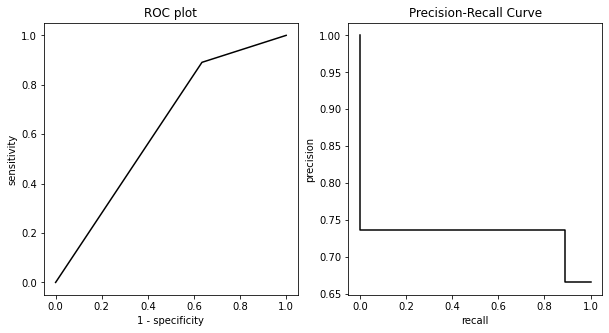

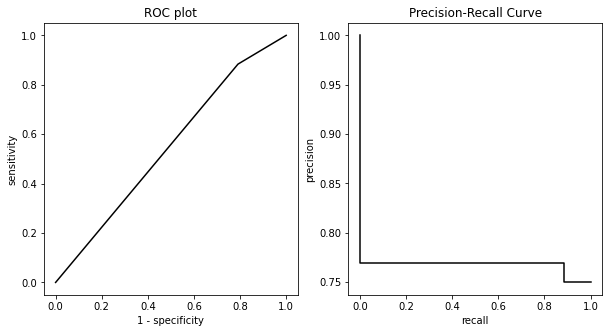

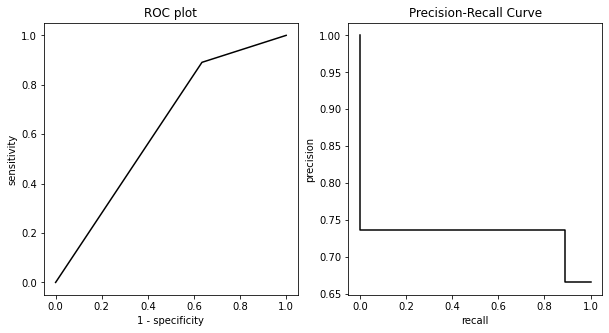

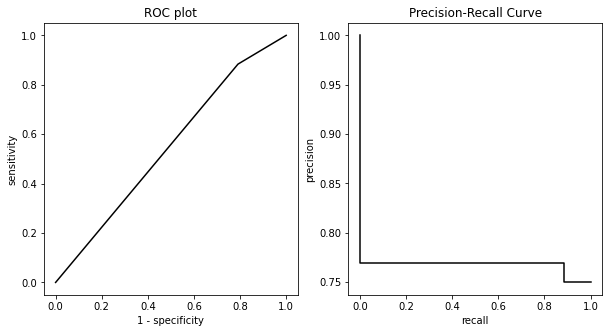

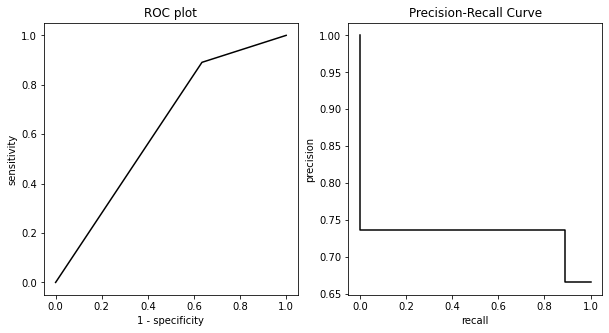

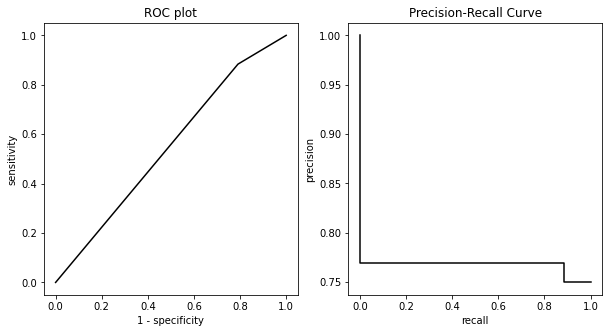

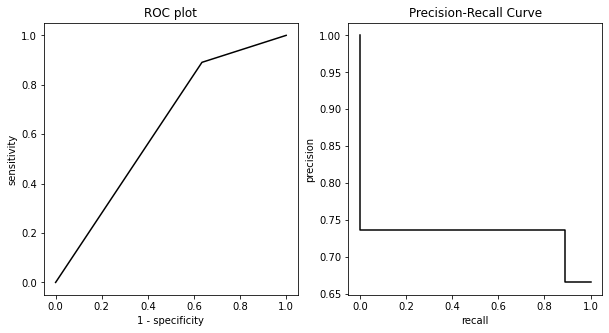

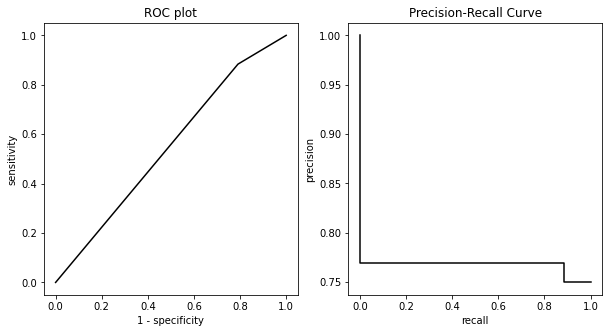

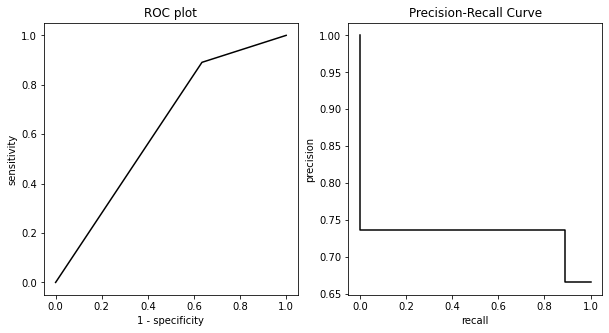

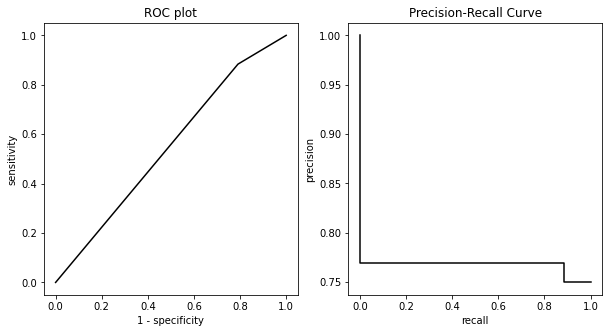

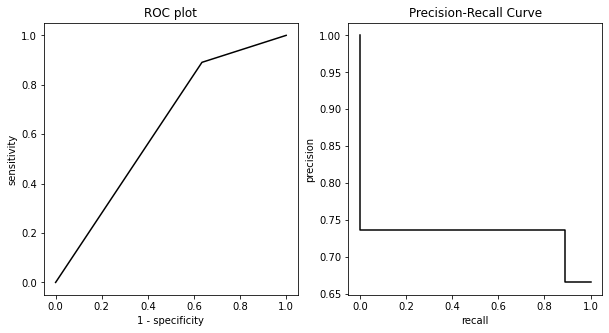

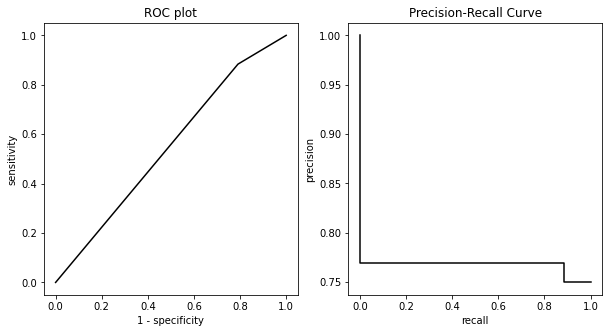

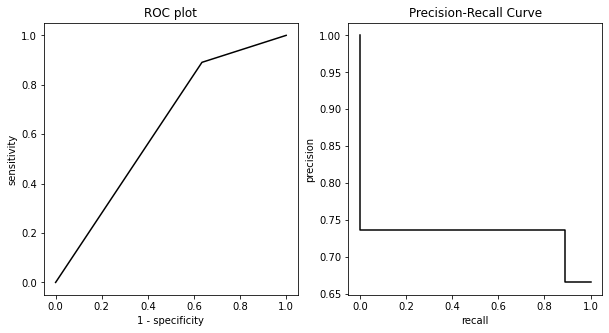

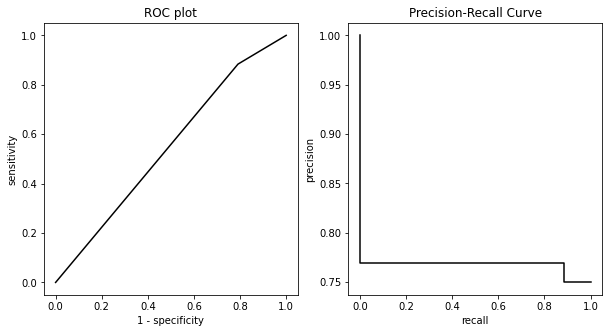

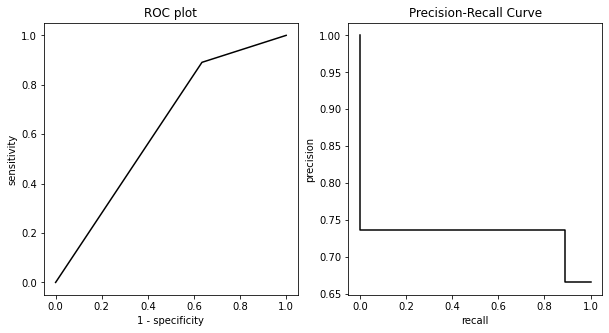

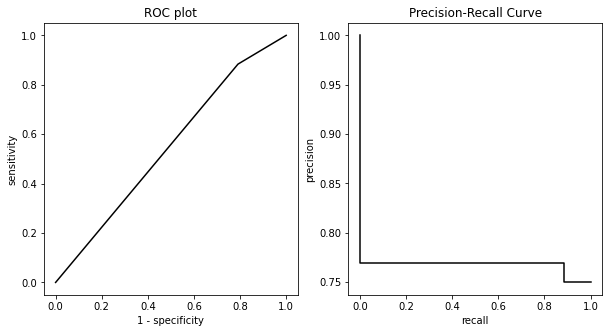

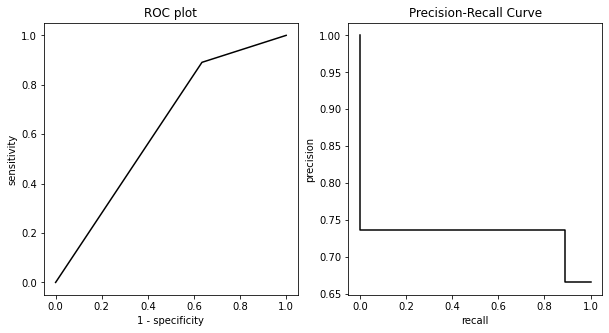

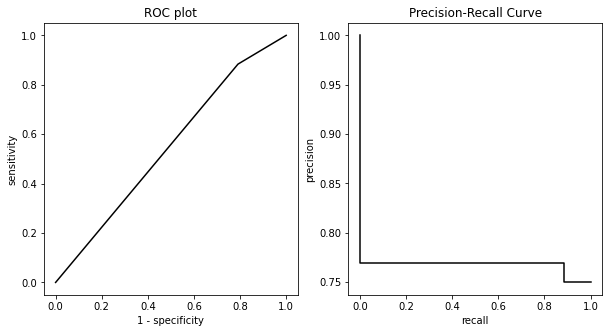

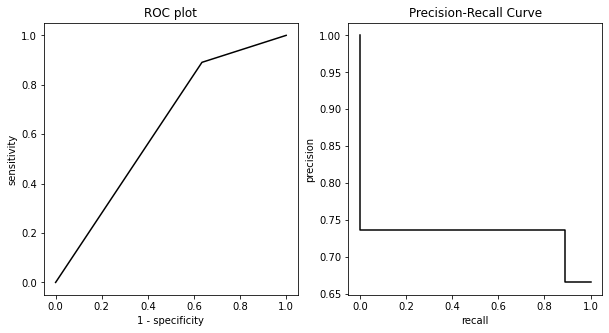

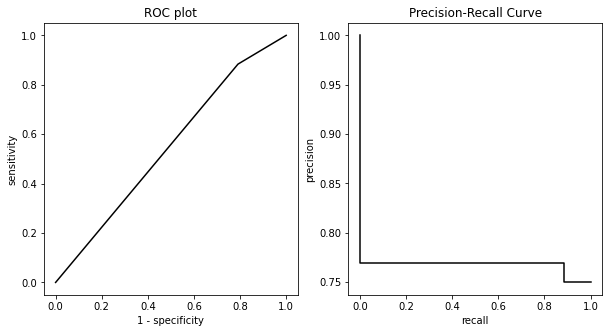

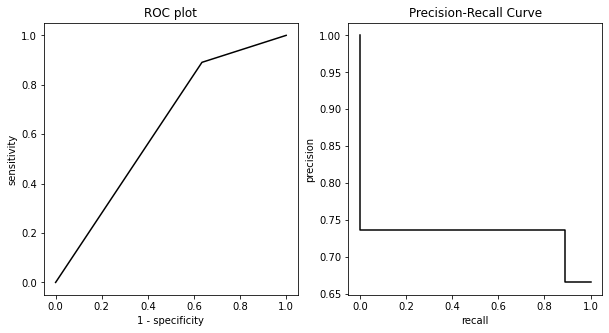

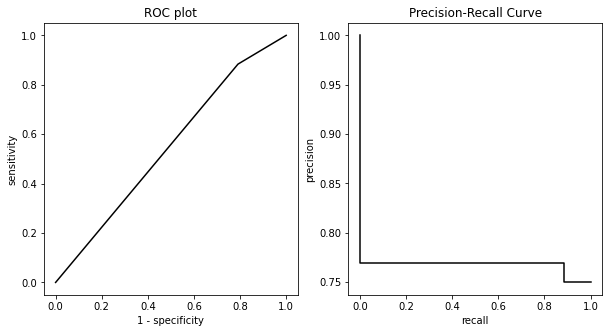

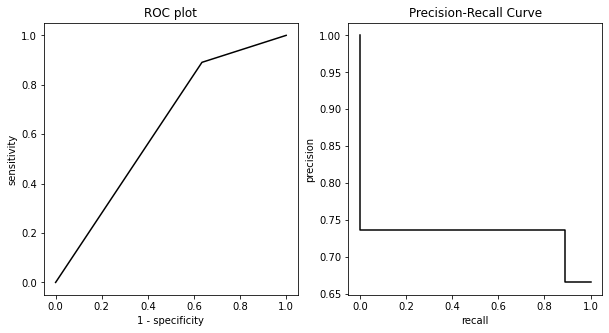

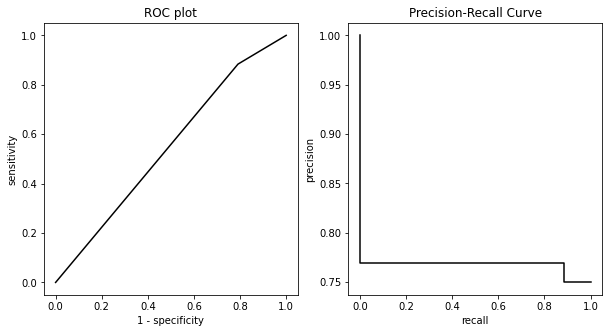

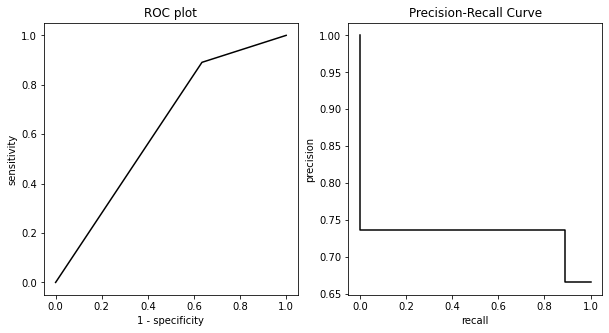

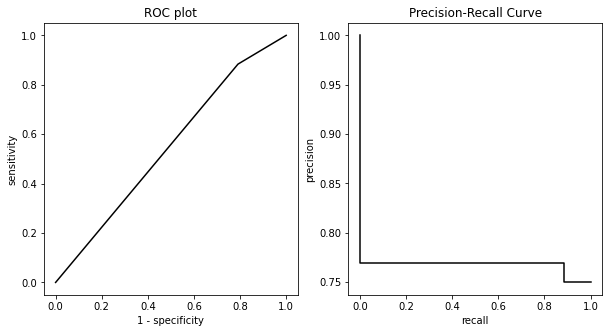

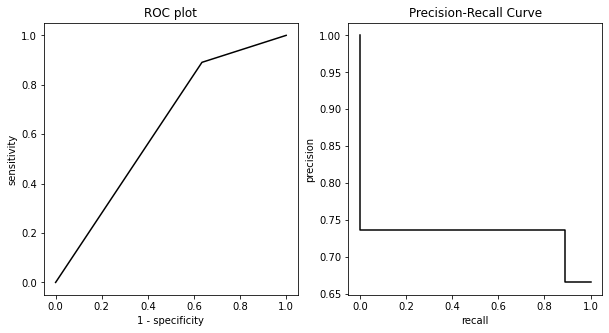

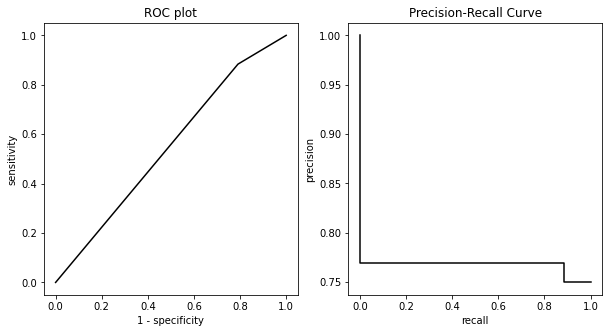

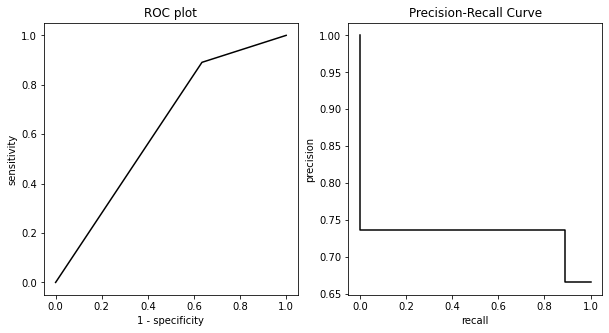

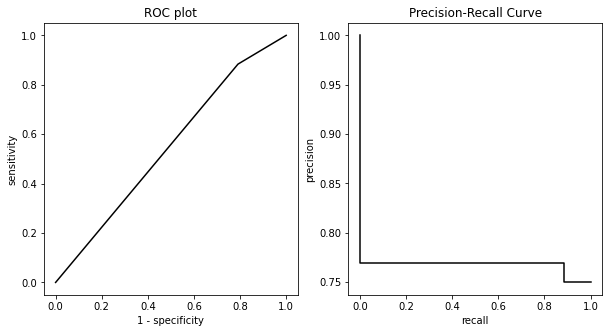

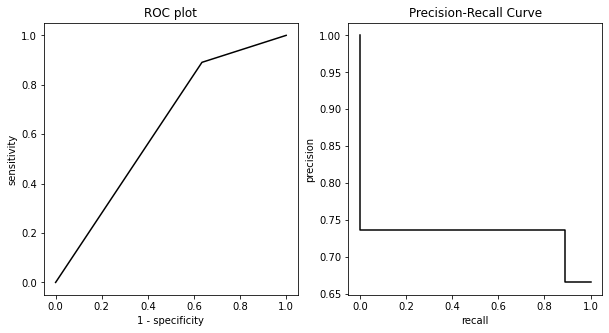

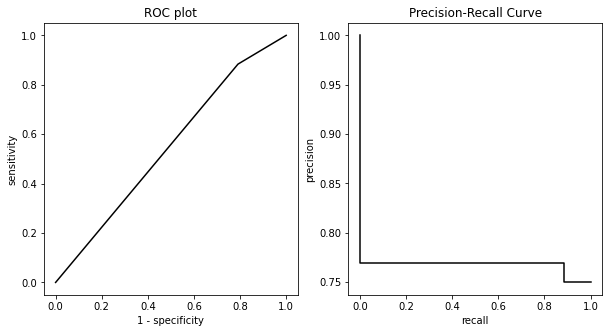

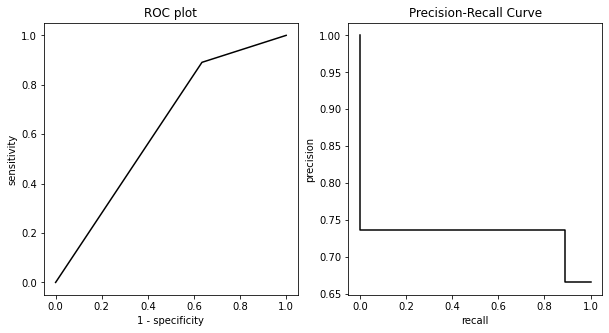

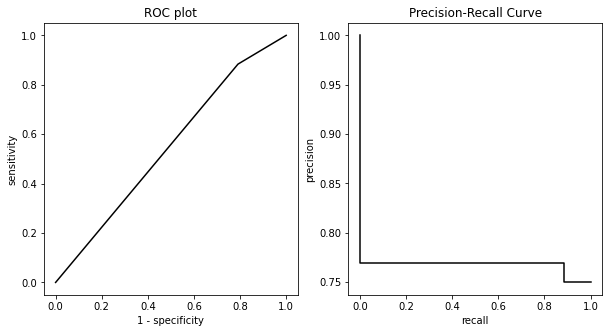

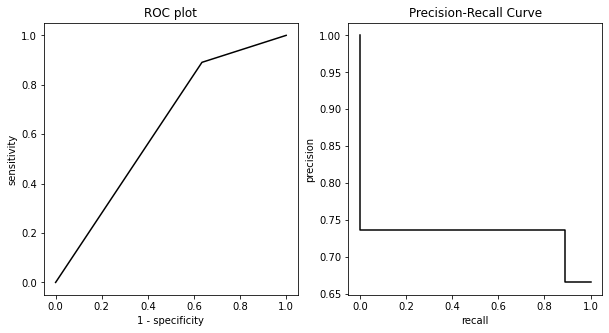

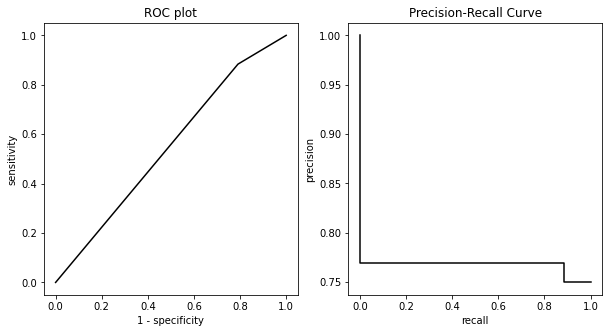

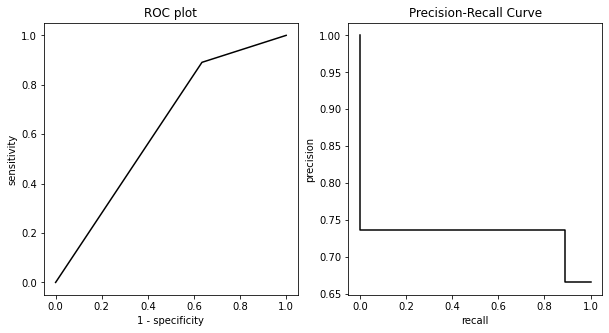

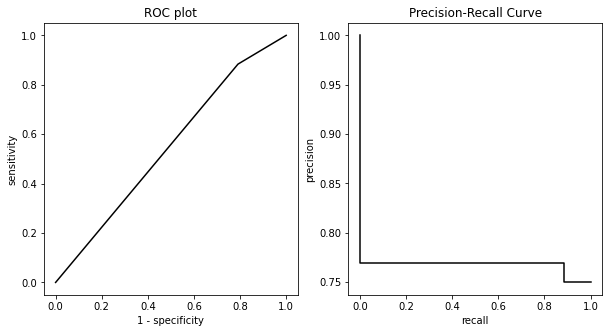

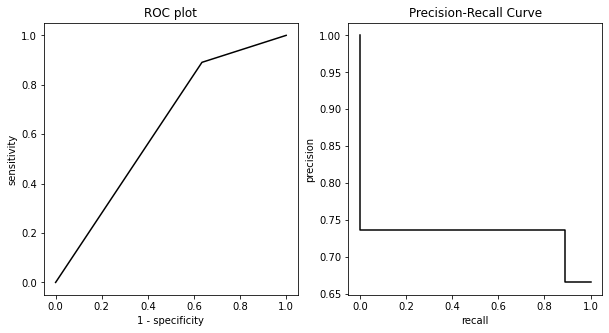

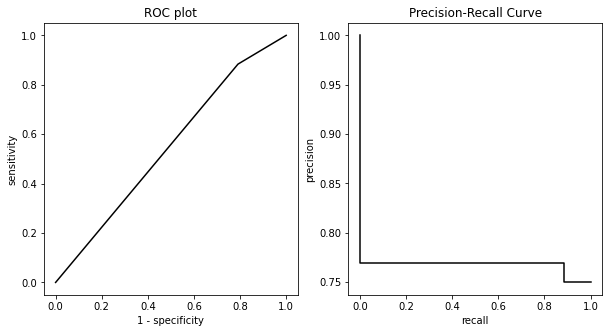

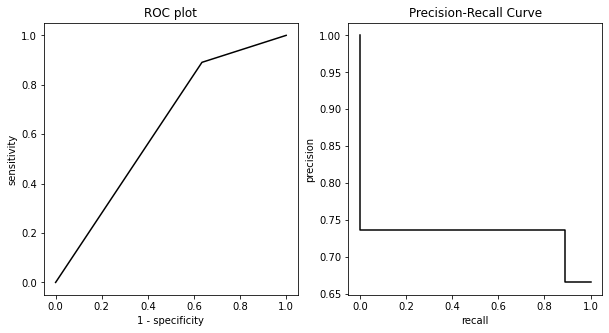

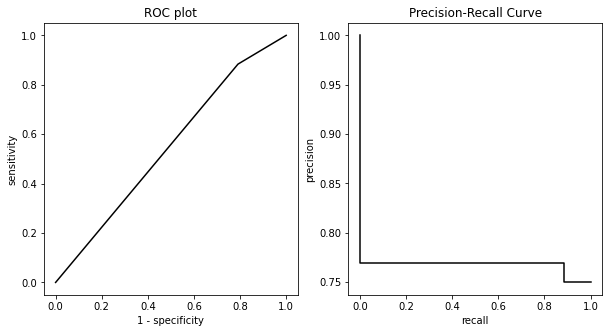

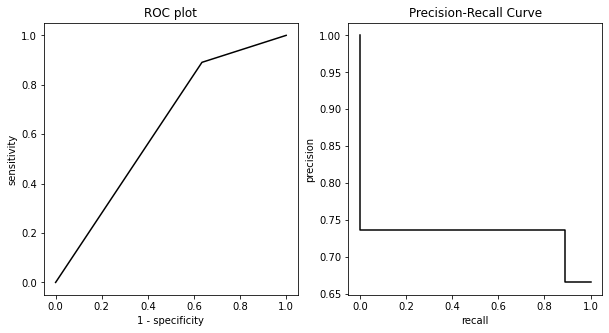

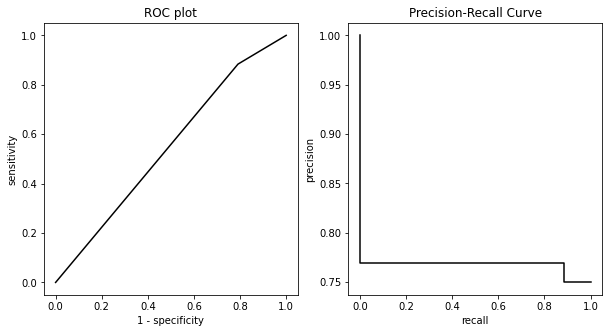

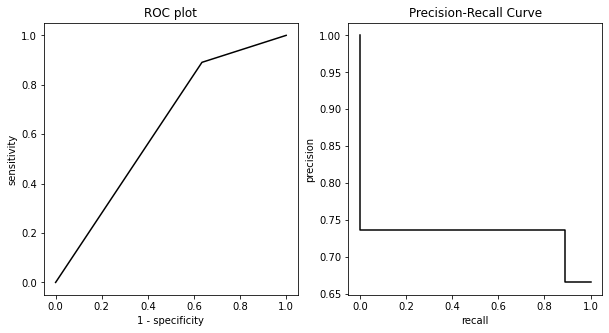

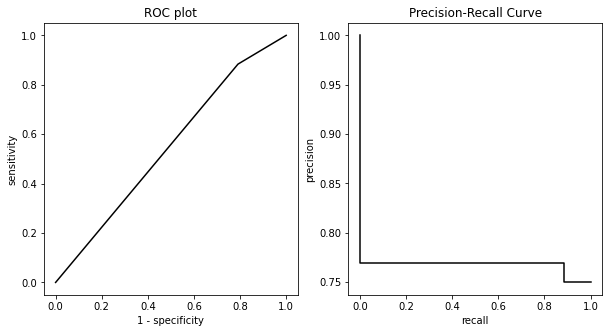

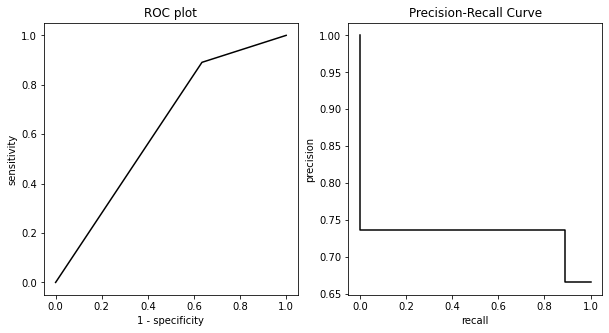

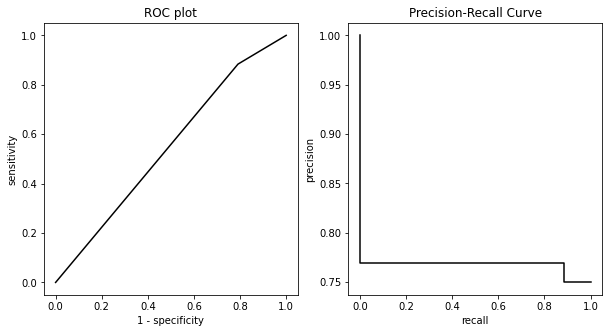

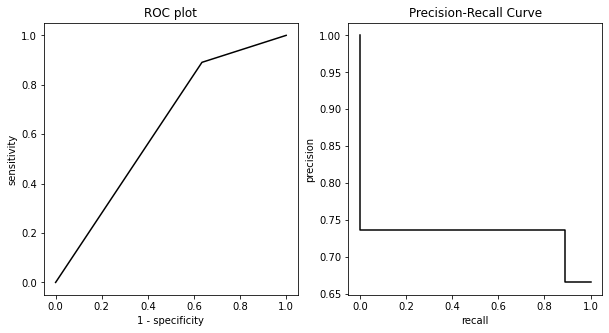

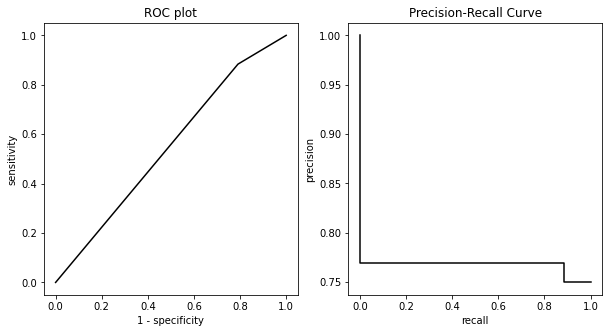

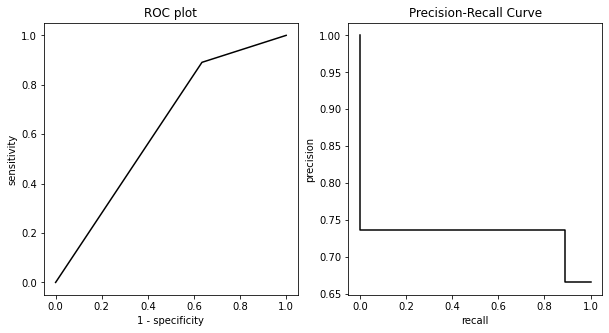

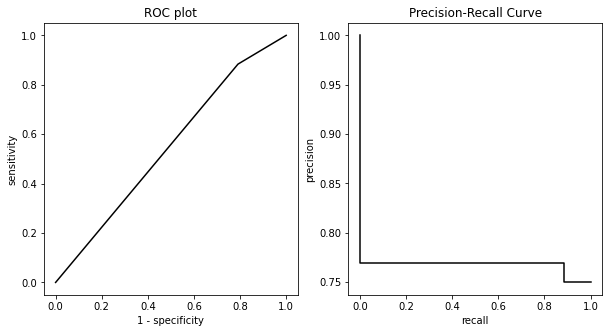

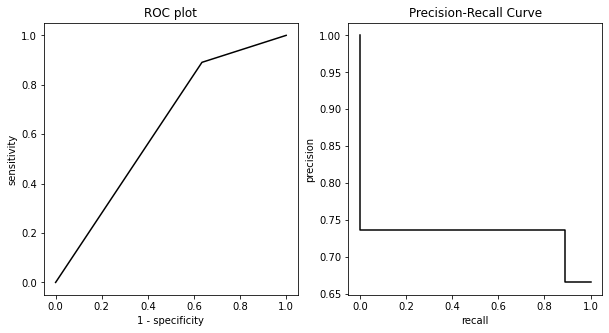

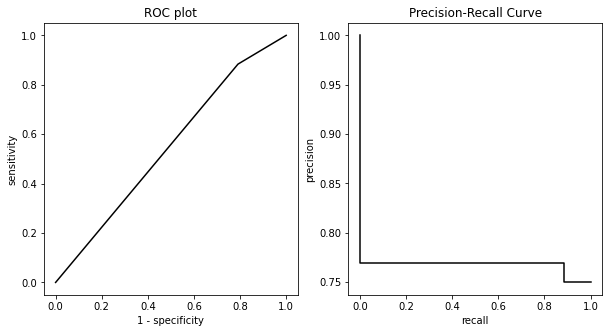

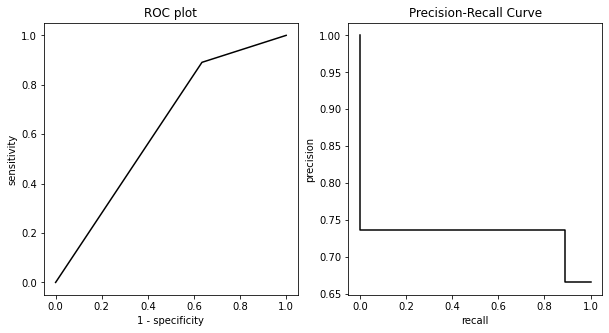

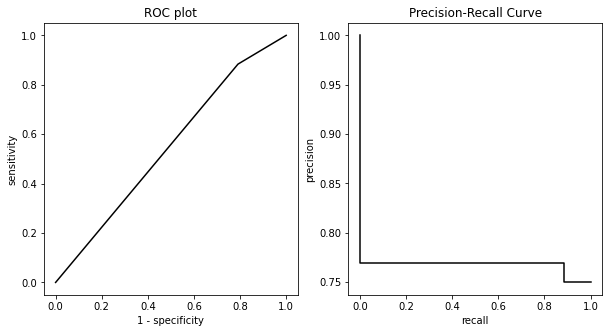

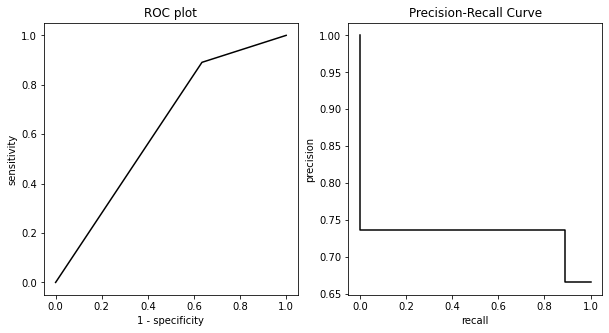

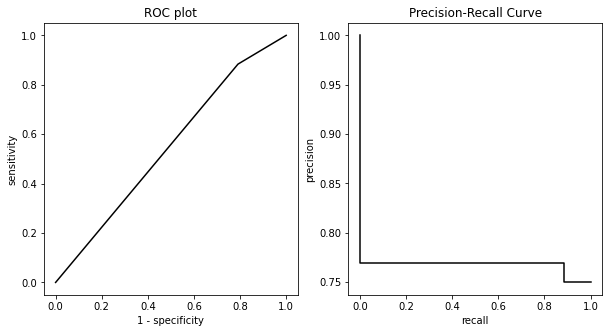

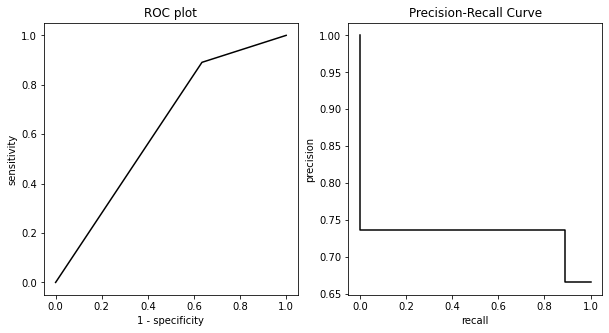

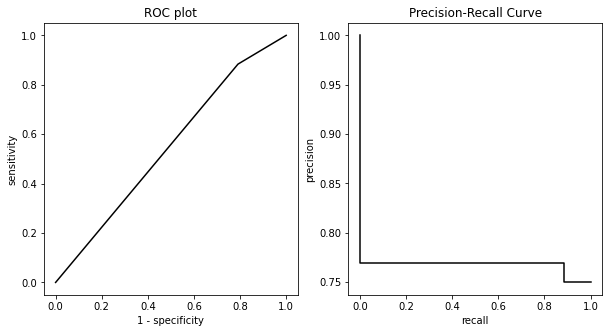

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

for i in range(n_runs):
  model = LogisticRegression(max_iter = 100)
  model.fit(train_data, train_labels)

  val_metrics = model_performance(
    model,
    val_data,
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    test_data,
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

In [ ]:
def mean_and_sd(l):
  return np.mean(l), np.sqrt(np.var(l))

val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)


print("LR")
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

LR
validation F1: 0.806 +/- 0.0
test F1: 0.823 +/- 0.0
validation accuracy: 0.715 +/- 0.0
test accuracy: 0.715 +/- 0.0
validation PR-AUC: 0.85 +/- 0.0
test PR-AUC: 0.87 +/- 0.0
validation ROC-AUC: 0.628 +/- 0.0
test ROC-AUC: 0.546 +/- 0.0


RF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

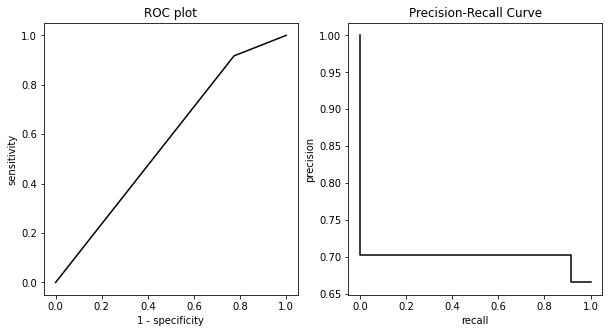

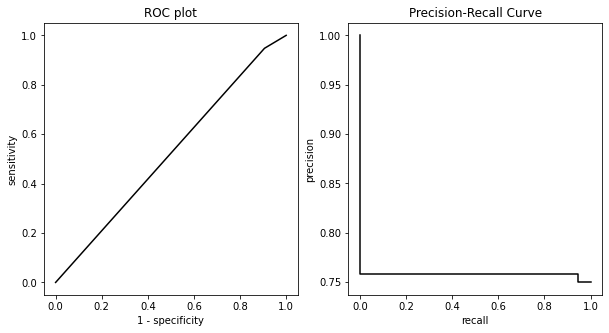

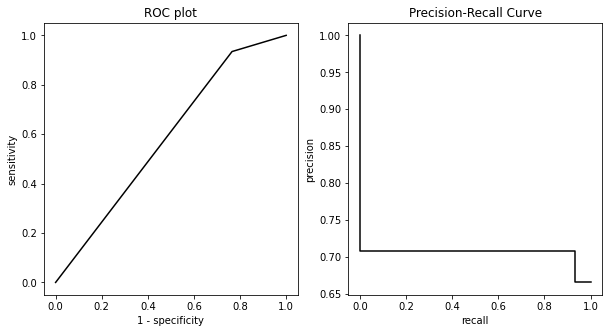

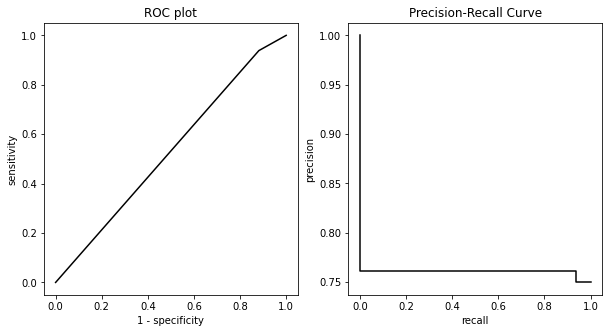

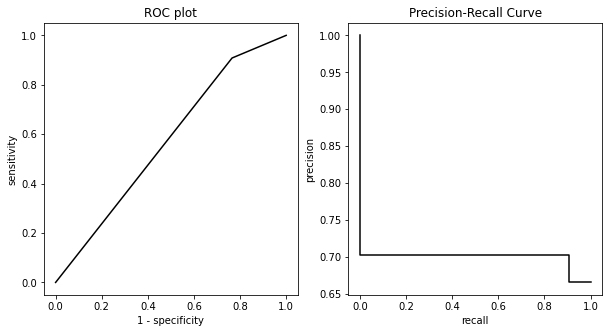

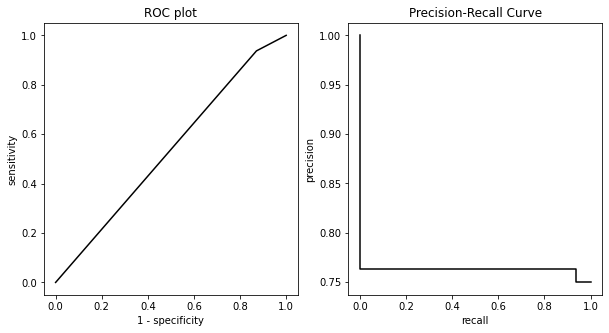

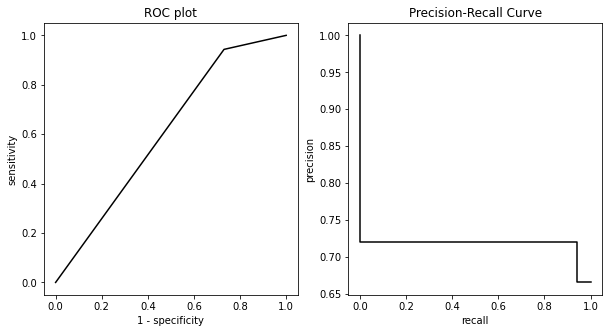

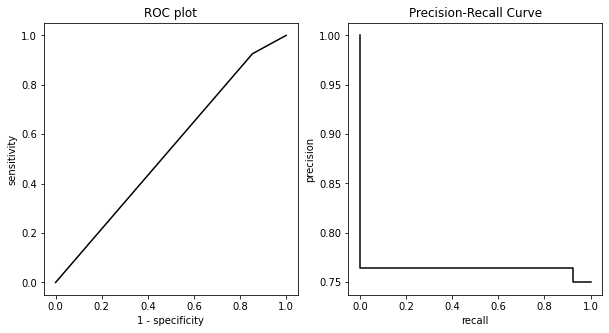

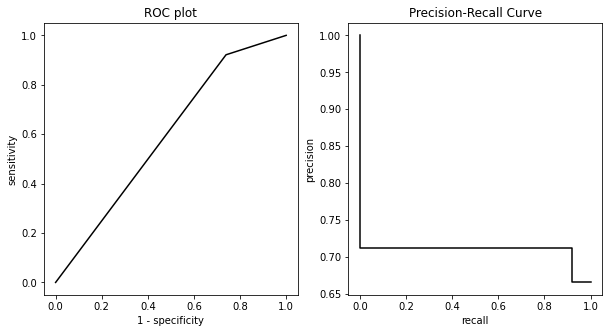

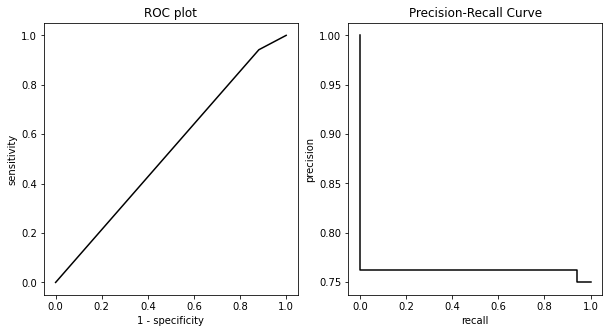

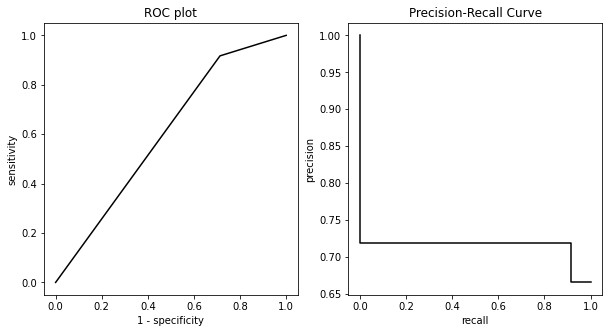

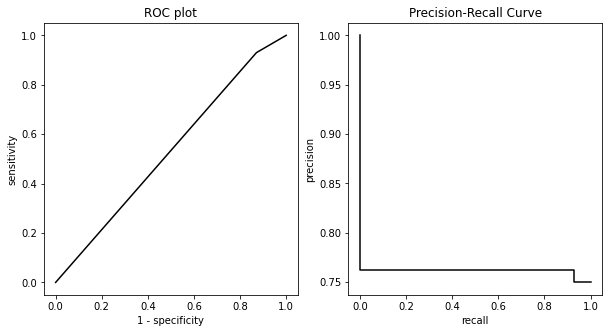

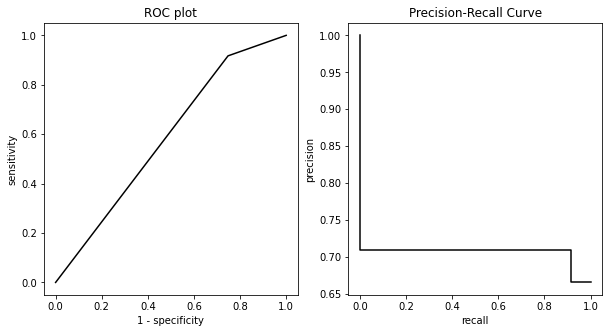

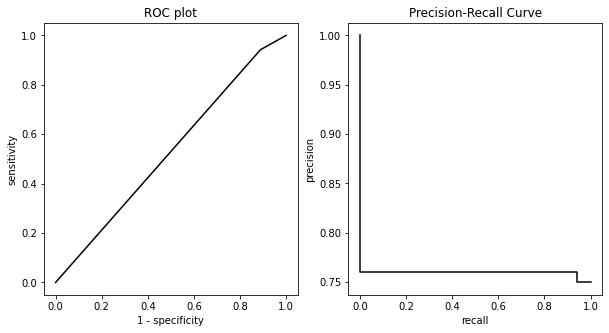

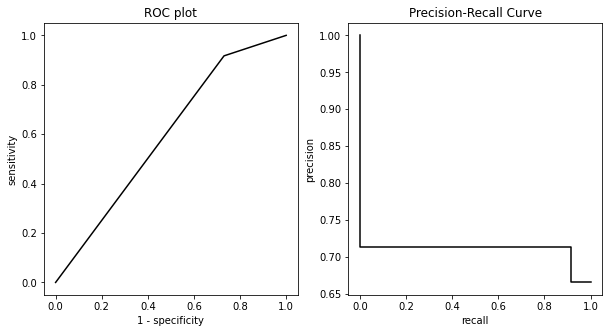

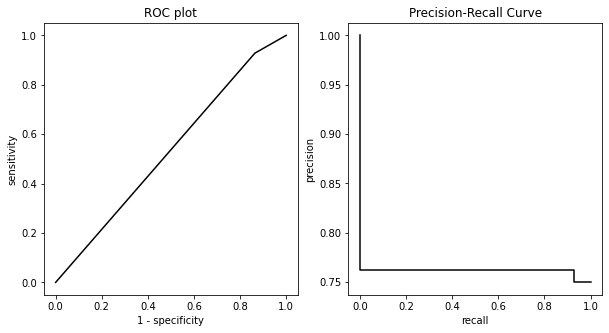

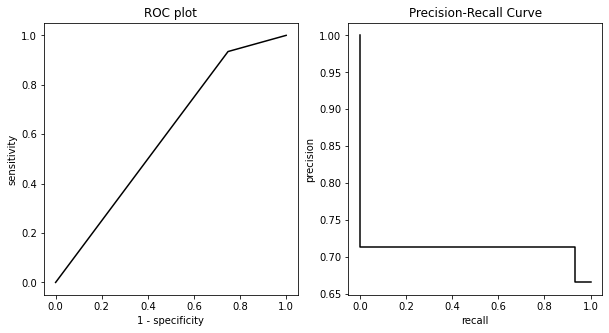

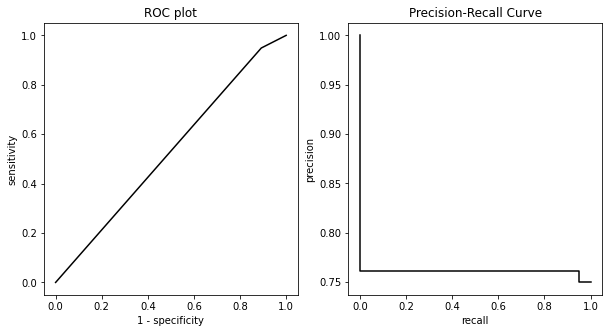

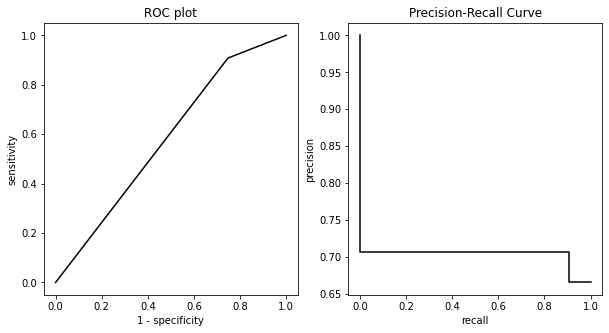

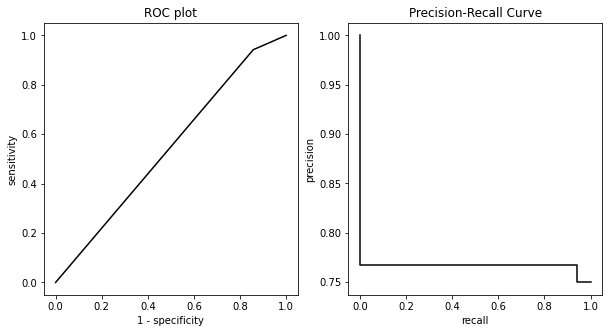

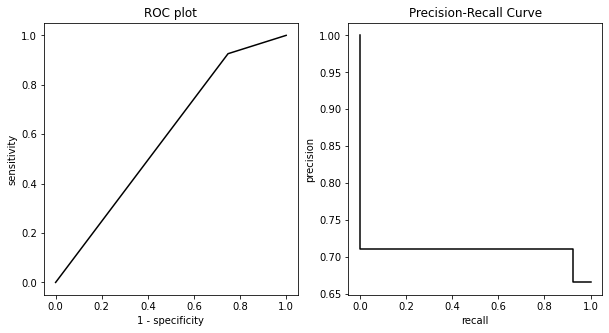

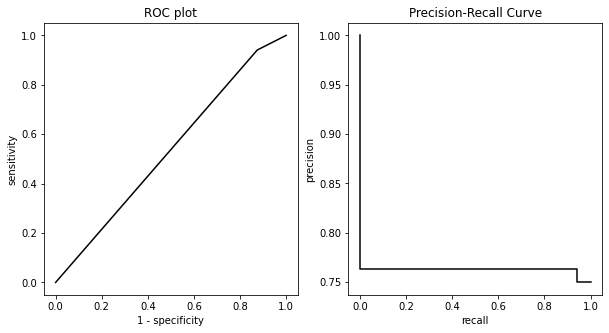

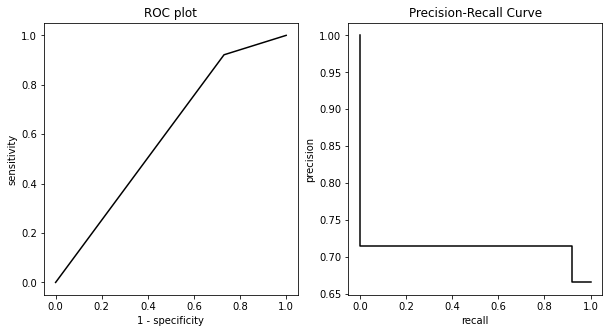

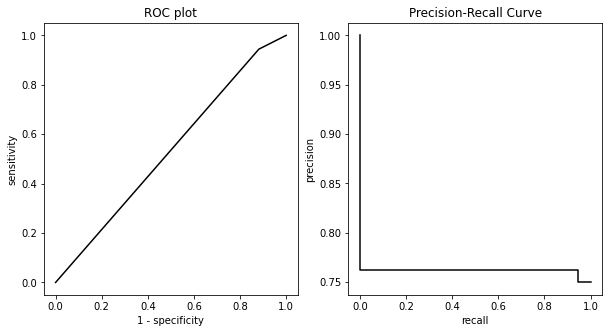

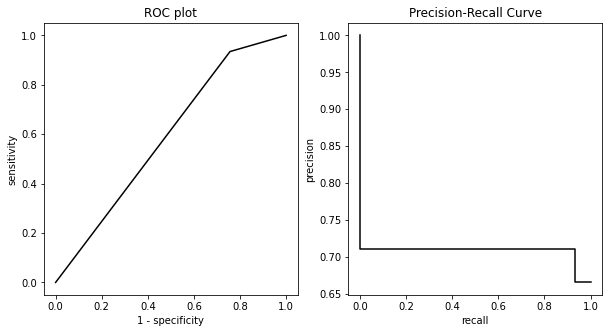

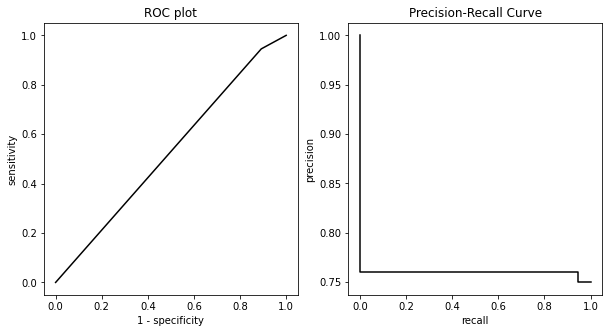

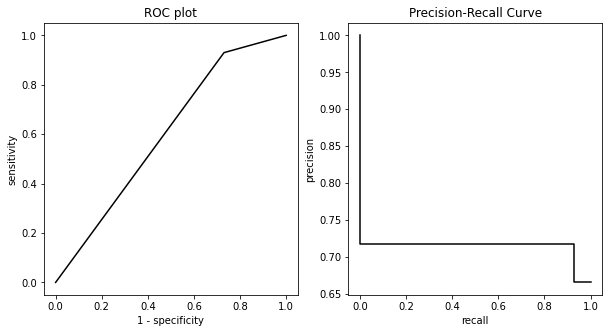

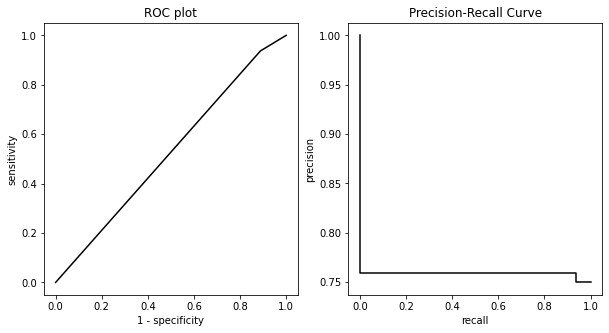

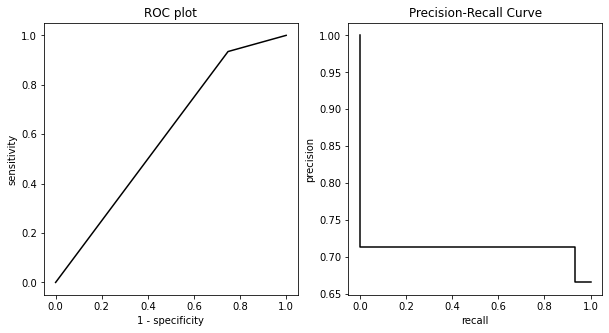

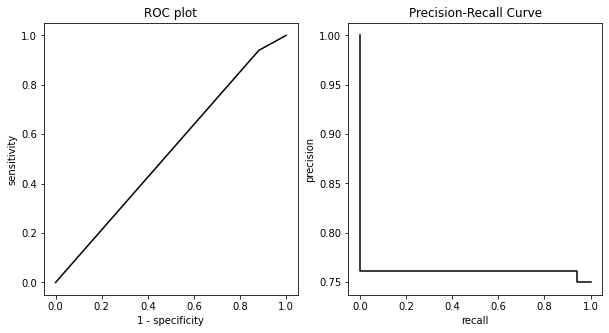

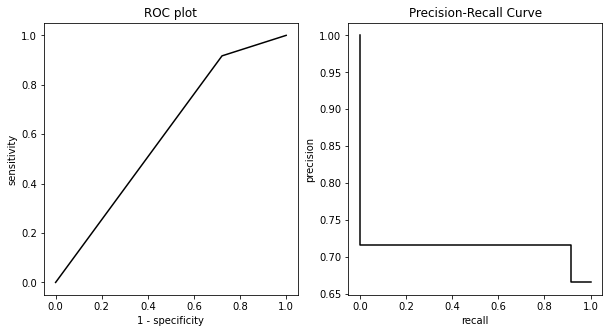

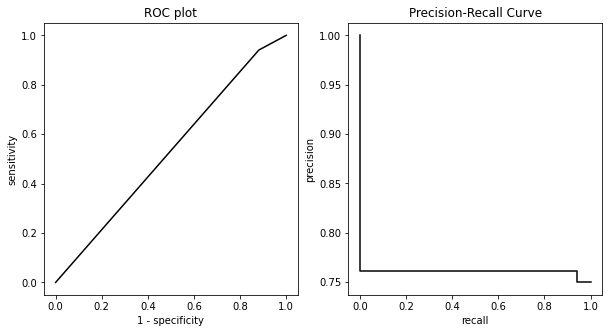

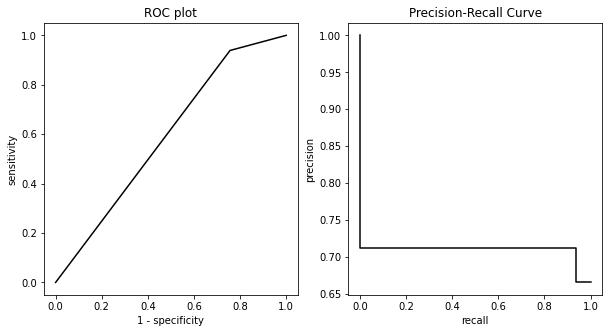

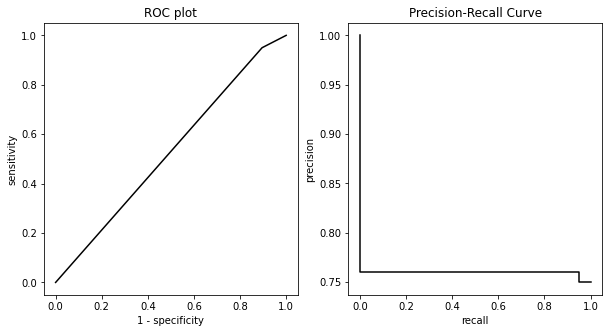

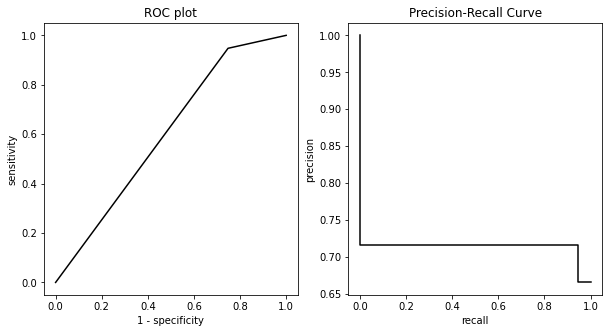

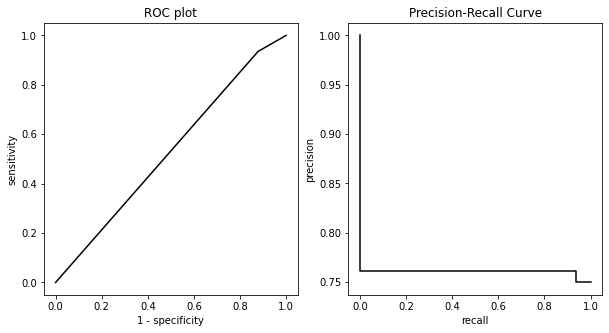

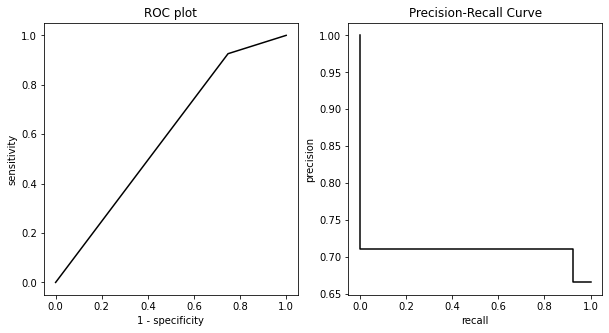

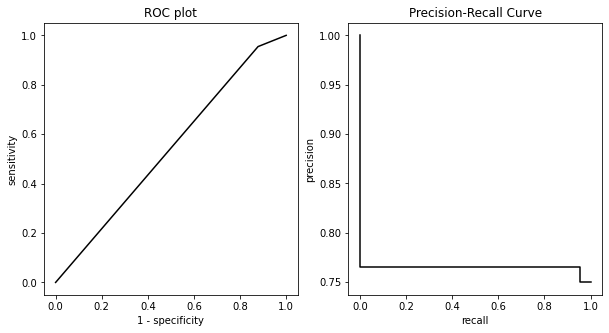

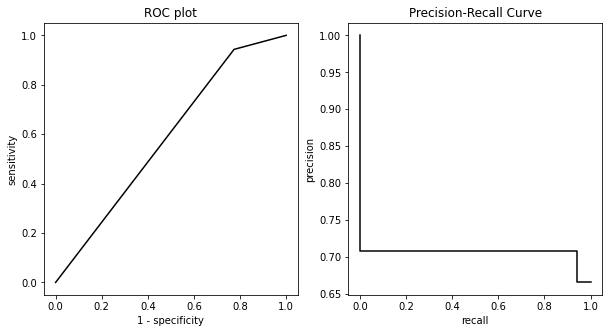

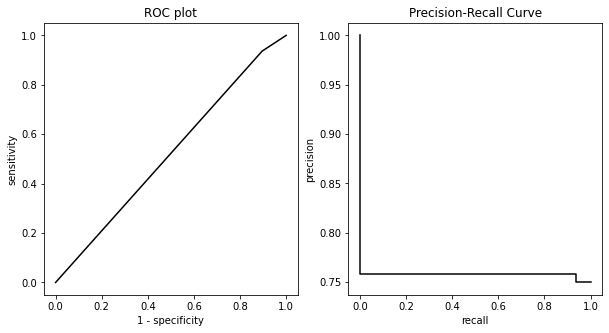

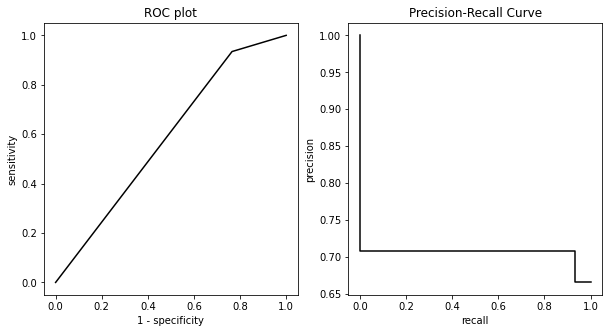

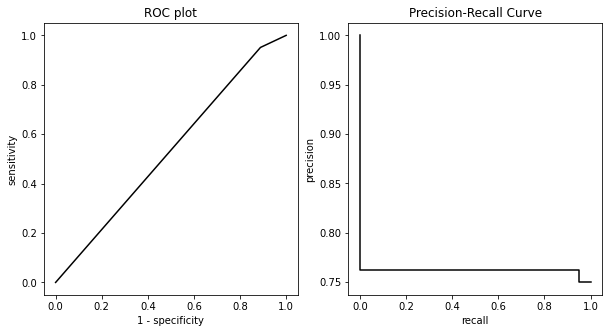

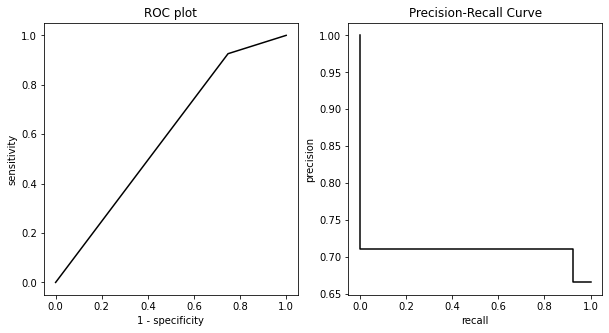

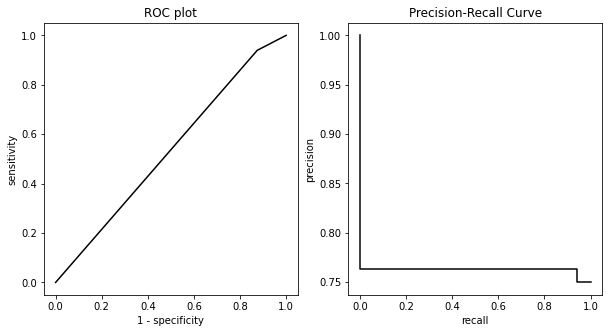

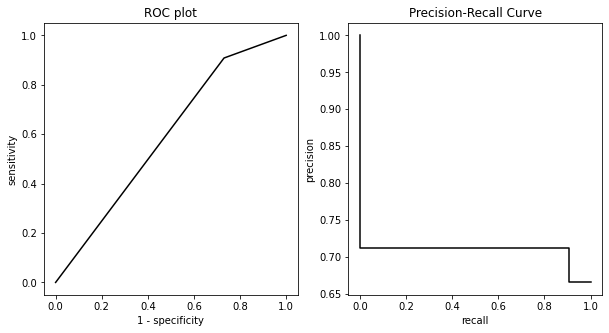

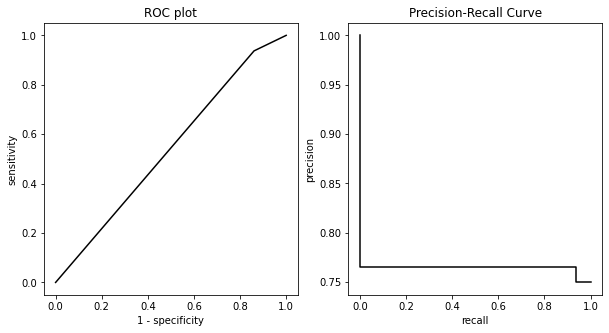

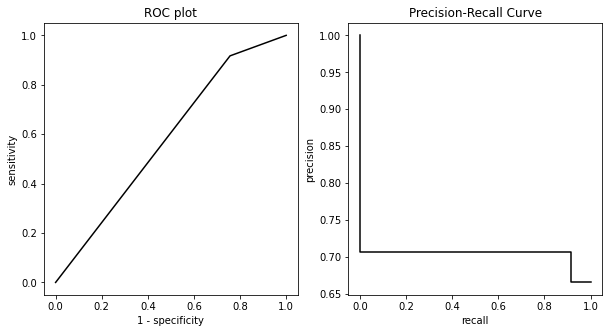

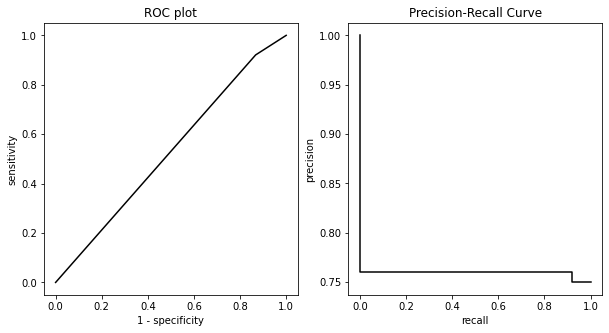

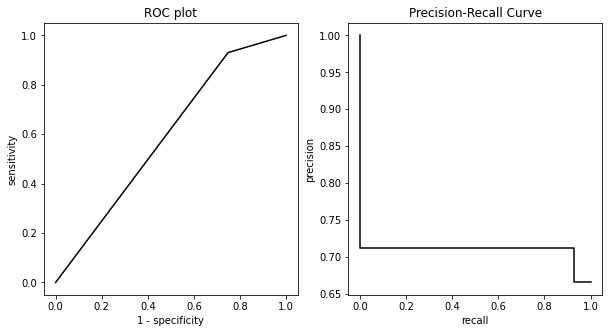

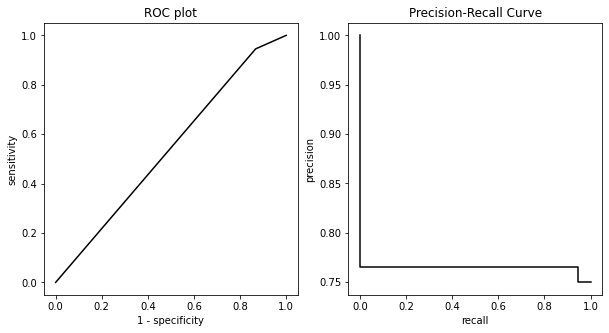

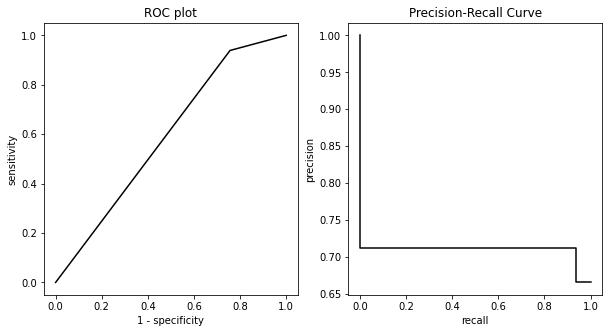

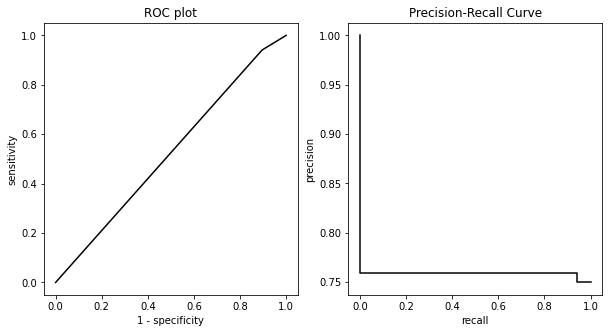

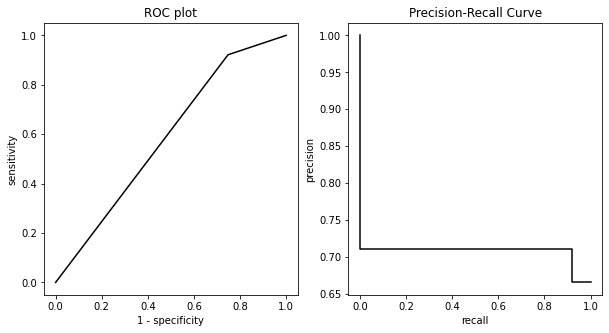

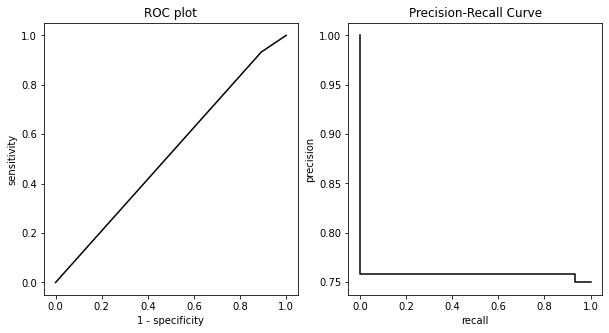

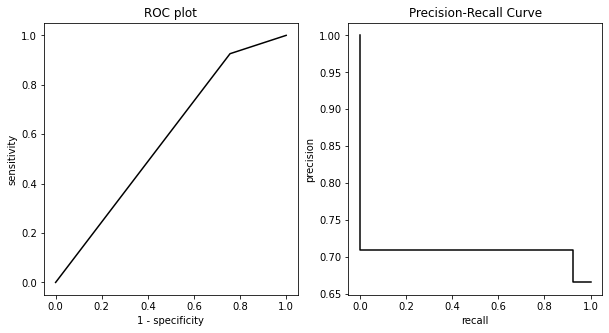

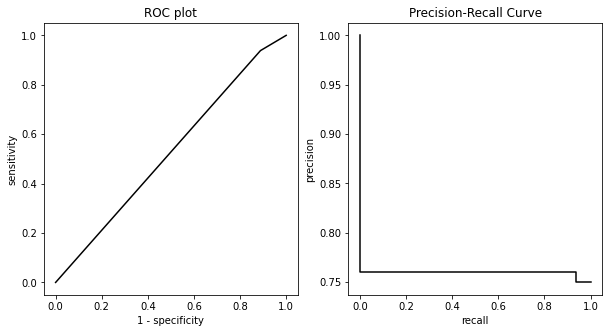

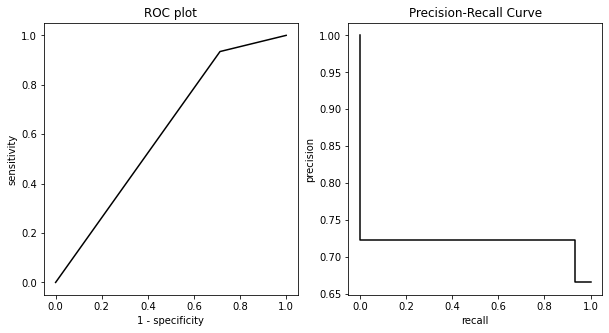

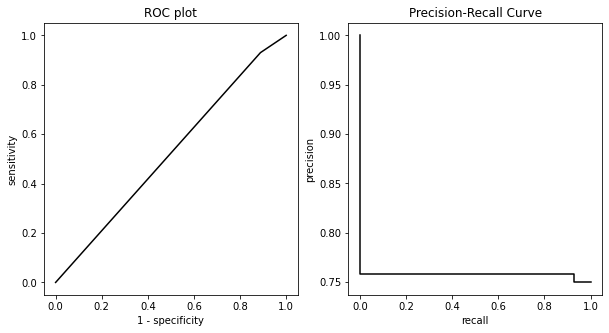

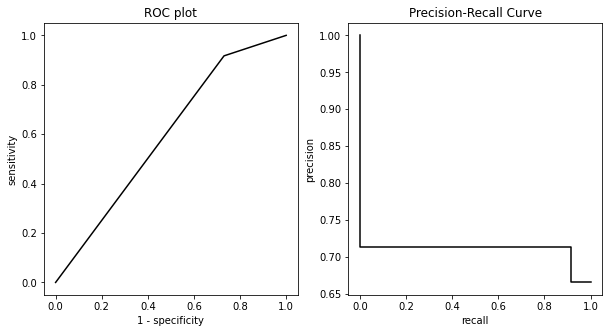

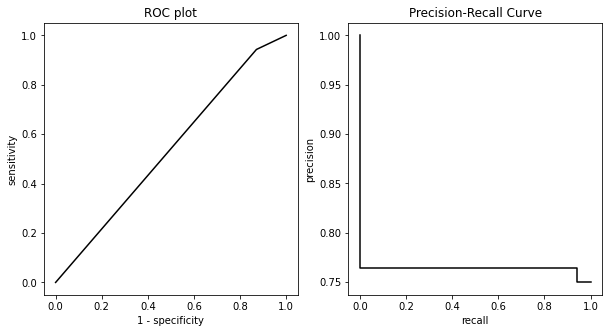

In [ ]:
val_F1 = np.zeros(n_runs, dtype=float)
val_acc = np.zeros(n_runs, dtype=float)
val_pr_auc = np.zeros(n_runs, dtype=float)
val_roc_auc = np.zeros(n_runs, dtype=float)

test_F1 = np.zeros(n_runs, dtype=float)
test_acc = np.zeros(n_runs, dtype=float)
test_pr_auc = np.zeros(n_runs, dtype=float)
test_roc_auc = np.zeros(n_runs, dtype=float)

for i in range(n_runs):
  model = RandomForestClassifier()
  model.fit(train_data, train_labels)

  val_metrics = model_performance(
    model,
    val_data,
    val_labels,
    save_path=None
  )

  test_metrics = model_performance(
    model,
    test_data,
    test_labels,
    save_path=None
  )

  val_F1[i] = val_metrics["F1"]
  val_acc[i] = val_metrics["accuracy"]
  val_pr_auc[i] = val_metrics["pr_auc"]
  val_roc_auc[i] = val_metrics["roc_auc"]

  test_F1[i] = test_metrics["F1"]
  test_acc[i] = test_metrics["accuracy"]
  test_pr_auc[i] = test_metrics["pr_auc"]
  test_roc_auc[i] = test_metrics["roc_auc"]

In [ ]:
val_F1_mean, val_F1_sd = mean_and_sd(val_F1)
val_acc_mean, val_acc_sd = mean_and_sd(val_acc)
val_pr_auc_mean, val_pr_auc_sd = mean_and_sd(val_pr_auc)
val_roc_auc_mean, val_roc_auc_sd = mean_and_sd(val_roc_auc)

test_F1_mean, test_F1_sd = mean_and_sd(test_F1)
test_acc_mean, test_acc_sd = mean_and_sd(test_acc)
test_pr_auc_mean, test_pr_auc_sd = mean_and_sd(test_pr_auc)
test_roc_auc_mean, test_roc_auc_sd = mean_and_sd(test_roc_auc)


print("RF")
print(f"validation F1: {round(val_F1_mean, 3)} +/- {round(val_F1_sd, 3)}")
print(f"test F1: {round(test_F1_mean, 3)} +/- {round(test_F1_sd, 3)}")

print(f"validation accuracy: {round(val_acc_mean, 3)} +/- {round(val_acc_sd, 3)}")
print(f"test accuracy: {round(test_acc_mean, 3)} +/- {round(test_acc_sd, 3)}")

print(f"validation PR-AUC: {round(val_pr_auc_mean, 3)} +/- {round(val_pr_auc_sd, 3)}")
print(f"test PR-AUC: {round(test_pr_auc_mean, 3)} +/- {round(test_pr_auc_sd, 3)}")

print(f"validation ROC-AUC: {round(val_roc_auc_mean, 3)} +/- {round(val_roc_auc_sd, 3)}")
print(f"test ROC-AUC: {round(test_roc_auc_mean, 3)} +/- {round(test_roc_auc_sd, 3)}")

RF
validation F1: 0.805 +/- 0.006
test F1: 0.841 +/- 0.004
validation accuracy: 0.702 +/- 0.008
test accuracy: 0.734 +/- 0.005
validation PR-AUC: 0.844 +/- 0.003
test PR-AUC: 0.873 +/- 0.002
validation ROC-AUC: 0.59 +/- 0.008
test ROC-AUC: 0.53 +/- 0.006


Streaming output truncated to the last 5000 lines.
Feature: 46705, Score: 0.00000
Feature: 46706, Score: 0.00000
Feature: 46707, Score: 0.00008
Feature: 46708, Score: 0.00000
Feature: 46709, Score: 0.00000
Feature: 46710, Score: 0.00000
Feature: 46711, Score: 0.00000
Feature: 46712, Score: 0.00000
Feature: 46713, Score: 0.00000
Feature: 46714, Score: 0.00005
Feature: 46715, Score: 0.00000
Feature: 46716, Score: 0.00000
Feature: 46717, Score: 0.00000
Feature: 46718, Score: 0.00000
Feature: 46719, Score: 0.00001
Feature: 46720, Score: 0.00000
Feature: 46721, Score: 0.00000
Feature: 46722, Score: 0.00000
Feature: 46723, Score: 0.00000
Feature: 46724, Score: 0.00000
Feature: 46725, Score: 0.00000
Feature: 46726, Score: 0.00000
Feature: 46727, Score: 0.00000
Feature: 46728, Score: 0.00000
Feature: 46729, Score: 0.00000
Feature: 46730, Score: 0.00000
Feature: 46731, Score: 0.00000
Feature: 46732, Score: 0.00000
Feature: 46733, Score: 0.00000
Feature: 46734, Score: 0.00000
Feature: 46735, Sco

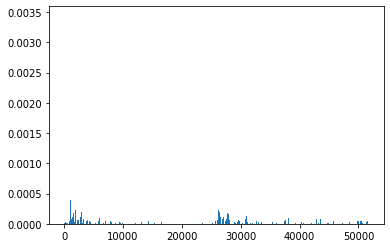

In [19]:
from matplotlib import pyplot

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()